# Week 14: Time-Frequency Analysis

Source: [MNE-Python](https://mne.tools/stable/index.html)

## 1. The Spectrum and EpochsSpectrum classes: frequency-domain data

This tutorial shows how to create and visualize frequency-domain representations of your
data, starting from continuous `~mne.io.Raw`, discontinuous `~mne.Epochs`,
or averaged `~mne.Evoked` data.

As usual we'll start by importing the modules we need, and loading our
`sample dataset`:

In [ ]:
import numpy as np

import mne
import matplotlib.pyplot as plt
%matplotlib qt5

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = sample_data_folder / "MEG" / "sample" / "sample_audvis_raw.fif"
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False).crop(tmax=60)

All three sensor-space containers (:class:`~mne.io.Raw`,
:class:`~mne.Epochs`, and :class:`~mne.Evoked`) have a
:meth:`~mne.io.Raw.compute_psd` method with the same options.

In [ ]:
raw.compute_psd()

By default, the spectral estimation method will be the
`Welch1967` method for continuous data, and the multitaper
method `Slepian1978` for epoched or averaged data. This default can
be overridden by passing ``method='welch'`` or ``method='multitaper'`` to the
`~mne.io.Raw.compute_psd` method.

There are many other options available as well; for example we can compute a
spectrum from a given span of times, for a chosen frequency range, and for a
subset of the available channels:

In [ ]:
raw.compute_psd(method="multitaper", tmin=10, tmax=20, fmin=5, fmax=30, picks="eeg")

You can also pass some parameters to the underlying spectral estimation
function, such as the FFT window length and overlap for the Welch method; see
the docstrings of :class:`mne.time_frequency.Spectrum` (esp. its
``method_kw`` parameter) and the spectral estimation functions
:func:`~mne.time_frequency.psd_array_welch` and
:func:`~mne.time_frequency.psd_array_multitaper` for details.

For epoched data, the class of the spectral estimate will be
:class:`mne.time_frequency.EpochsSpectrum` instead of
:class:`mne.time_frequency.Spectrum`, but most of the API is the same for the
two classes. For example, both have a
:meth:`~mne.time_frequency.EpochsSpectrum.get_data` method with an option to
return the bin frequencies:

In [ ]:
with mne.use_log_level("WARNING"):  # hide some irrelevant info messages
    events = mne.find_events(raw, stim_channel="STI 014")
    event_dict = {
        "auditory/left": 1,
        "auditory/right": 2,
        "visual/left": 3,
        "visual/right": 4,
    }
    epochs = mne.Epochs(
        raw, events, tmin=-0.3, tmax=0.7, event_id=event_dict, preload=True
    )
epo_spectrum = epochs.compute_psd()
psds, freqs = epo_spectrum.get_data(return_freqs=True)
print(f"\nPSDs shape: {psds.shape}, freqs shape: {freqs.shape}")
epo_spectrum

Additionally, both :class:`~mne.time_frequency.Spectrum` and
:class:`~mne.time_frequency.EpochsSpectrum` have ``__getitem__`` methods,
meaning their data can be accessed by square-bracket indexing. For
:class:`~mne.time_frequency.Spectrum` objects (computed from
:class:`~mne.io.Raw` or :class:`~mne.Evoked` data), the indexing works
similar to a :class:`~mne.io.Raw` object or a
:class:`NumPy array<numpy.ndarray>`:

In [ ]:
evoked = epochs["auditory"].average()
evk_spectrum = evoked.compute_psd()
# the first 3 frequency bins for the first 4 channels:
print(evk_spectrum[:4, :3])


```
   If the original :class:`~mne.Epochs` object had a metadata dataframe
   attached, the derived :class:`~mne.time_frequency.EpochsSpectrum` will
   inherit that metadata and will hence also support subselecting epochs via
   `Pandas query strings <pandas:indexing.query>`.
```

In contrast, the :class:`~mne.time_frequency.EpochsSpectrum` has indexing
similar to :class:`~mne.Epochs` objects: you can use string values to select
spectral estimates for specific epochs based on their condition names, and
what you get back is a new instance of
:class:`~mne.time_frequency.EpochsSpectrum` rather than a
:class:`NumPy array<numpy.ndarray>` of the data values. Selection via
:term:`hierarchical event descriptors` (HEDs) is also possible:

In [ ]:
# get both "visual/left" and "visual/right" epochs:
epo_spectrum["visual"]

### Visualizing Spectrum objects

Both `~mne.time_frequency.Spectrum` and
`~mne.time_frequency.EpochsSpectrum` objects have plotting methods
`~mne.time_frequency.Spectrum.plot` (frequency × power),
`~mne.time_frequency.Spectrum.plot_topo` (frequency × power separately
for each sensor), and `~mne.time_frequency.Spectrum.plot_topomap`
(interpolated scalp topography of power, in specific frequency bands). A few
plot options are demonstrated below; see the docstrings for full details.

In [ ]:
evk_spectrum.plot(picks="data", exclude="bads", amplitude=False)
evk_spectrum.plot_topo(color="k", fig_facecolor="w", axis_facecolor="w")

In [ ]:
evk_spectrum.plot_topomap(ch_type="eeg", agg_fun=np.median)

## Migrating legacy code

Below is a quick-reference table of equivalent code from before and after the
introduction of the `~mne.time_frequency.Spectrum` and
`~mne.time_frequency.EpochsSpectrum` classes.

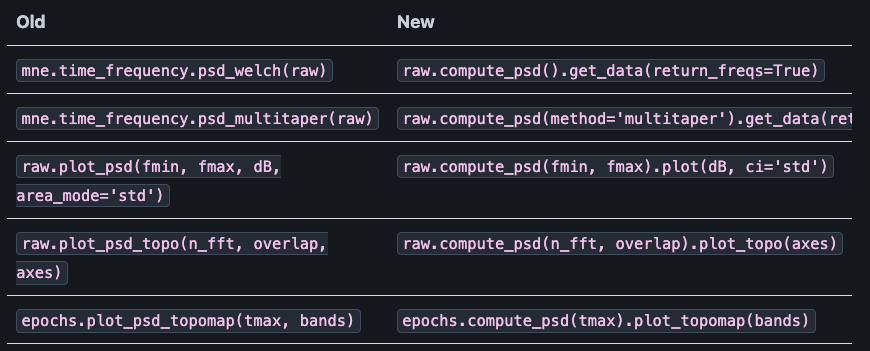


```
The functions mne.time_frequency.psd_welch and mne.time_frequency.psd_multitaper have been removed; new code should use the Raw.compute_psd(), Epochs.compute_psd(), and Evoked.compute_psd() methods, and pass method='welch' or method='multitaper' as a parameter.

The class methods Raw.plot_psd(), Epochs.plot_psd(), Raw.plot_psd_topo(), and Epochs.plot_psd_topomap() have been kept in the API to support legacy code, but should be avoided when writing new code.

```

## 2. Frequency and time-frequency sensor analysis

The objective is to show you how to explore the spectral content
of your data (frequency and time-frequency). Here we'll work on Epochs.

We will use this dataset: `somato-dataset`. It contains so-called event
related synchronizations (ERS) / desynchronizations (ERD) in the beta band.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets import somato

Set parameters

In [ ]:
data_path = somato.data_path()
subject = "01"
task = "somato"
raw_fname = data_path / f"sub-{subject}" / "meg" / f"sub-{subject}_task-{task}_meg.fif"

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)
# crop and resample just to reduce computation time
raw.crop(120, 360).load_data().resample(200)
events = mne.find_events(raw, stim_channel="STI 014")

# picks MEG gradiometers
picks = mne.pick_types(raw.info, meg="grad", eeg=False, eog=True, stim=False)

# Construct Epochs
event_id, tmin, tmax = 1, -1.0, 3.0
baseline = (None, 0)
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=baseline,
    reject=dict(grad=4000e-13, eog=350e-6),
    preload=True,
)

### Frequency analysis

We start by exploring the frequency content of our epochs.

Let's first check out all channel types by averaging across epochs.

In [ ]:
epochs.compute_psd(fmin=2.0, fmax=40.0).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)

Now, let's take a look at the spatial distributions of the PSD, averaged
across epochs and frequency bands.

In [ ]:
epochs.compute_psd().plot_topomap(ch_type="grad", normalize=False, contours=0)

Alternatively, you can also create PSDs from `~mne.Epochs` methods directly.

<div class="alert alert-info"><h4>Note</h4><p>In contrast to the methods for visualization, the ``compute_psd`` methods
   do **not** scale the data from SI units to more "convenient" values. So
   when e.g. calculating the PSD of gradiometers via
   :meth:`~mne.Epochs.compute_psd`, you will get the power as
   ``(T/m)²/Hz`` (instead of ``(fT/cm)²/Hz`` via
   :meth:`~mne.Epochs.plot_psd`).</p></div>

In [ ]:
_, ax = plt.subplots()
spectrum = epochs.compute_psd(fmin=2.0, fmax=40.0, tmax=3.0, n_jobs=None)
# average across epochs first
mean_spectrum = spectrum.average()
psds, freqs = mean_spectrum.get_data(return_freqs=True)
# then convert to dB and take mean & standard deviation across channels
psds = 10 * np.log10(psds)
psds_mean = psds.mean(axis=0)
psds_std = psds.std(axis=0)

ax.plot(freqs, psds_mean, color="k")
ax.fill_between(
    freqs,
    psds_mean - psds_std,
    psds_mean + psds_std,
    color="k",
    alpha=0.5,
    edgecolor="none",
)
ax.set(
    title="Multitaper PSD (gradiometers)",
    xlabel="Frequency (Hz)",
    ylabel="Power Spectral Density (dB)",
)

Notably, `mne.Epochs.compute_psd` supports the keyword argument
``average``, which specifies how to estimate the PSD based on the individual
windowed segments. The default is ``average='mean'``, which simply calculates
the arithmetic mean across segments. Specifying ``average='median'``, in
contrast, returns the PSD based on the median of the segments (corrected for
bias relative to the mean), which is a more robust measure.

In [ ]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=40, n_jobs=None)
psds_welch_mean, freqs_mean = epochs.compute_psd(
    "welch", average="mean", **kwargs
).get_data(return_freqs=True)
psds_welch_median, freqs_median = epochs.compute_psd(
    "welch", average="median", **kwargs
).get_data(return_freqs=True)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = "MEG 0122"
ch_idx = epochs.info["ch_names"].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(
    freqs_mean,
    psds_welch_mean[epo_idx, ch_idx, :],
    color="k",
    ls="-",
    label="mean of segments",
)
ax.plot(
    freqs_median,
    psds_welch_median[epo_idx, ch_idx, :],
    color="k",
    ls="--",
    label="median of segments",
)

ax.set(
    title=f"Welch PSD ({ch_name}, Epoch {epo_idx})",
    xlabel="Frequency (Hz)",
    ylabel="Power Spectral Density (dB)",
)
ax.legend(loc="upper right")

Lastly, we can also retrieve the unaggregated segments by passing
``average=None`` to `mne.Epochs.compute_psd`. The dimensions of
the returned array are ``(n_epochs, n_sensors, n_freqs, n_segments)``.

In [ ]:
welch_unagg = epochs.compute_psd("welch", average=None, **kwargs)
print(welch_unagg.shape)

## Time-frequency analysis: power and inter-trial coherence

We now compute time-frequency representations (TFRs) from our Epochs.
We'll look at power and inter-trial coherence (ITC).

To this we'll use the function `mne.time_frequency.tfr_morlet`
but you can also use `mne.time_frequency.tfr_multitaper`
or `mne.time_frequency.tfr_stockwell`.

<div class="alert alert-info"><h4>Note</h4><p>The ``decim`` parameter reduces the sampling rate of the time-frequency
      decomposition by the defined factor. This is usually done to reduce
      memory usage. For more information refer to the documentation of
      :func:`mne.time_frequency.tfr_morlet`.</p></div>

define frequencies of interest (log-spaced)

In [ ]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(
    epochs, freqs=freqs, n_cycles=n_cycles, return_itc=True, average=True, decim=3
)

### Inspect power

<div class="alert alert-info"><h4>Note</h4><p>The generated figures are interactive. In the topo you can click
    on an image to visualize the data for one sensor.
    You can also select a portion in the time-frequency plane to
    obtain a topomap for a certain time-frequency region.</p></div>

In [ ]:
power.plot_topo(baseline=(-0.5, 0), mode="logratio", title="Average power")
power.plot(picks=[82], baseline=(-0.5, 0), mode="logratio", title=power.ch_names[82])

fig, axes = plt.subplots(1, 2, figsize=(7, 4), layout="constrained")
topomap_kw = dict(
    ch_type="grad", tmin=0.5, tmax=1.5, baseline=(-0.5, 0), mode="logratio", show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title(title)

### Joint Plot

You can also create a joint plot showing both the aggregated TFR
across channels and topomaps at specific times and frequencies to obtain
a quick overview regarding oscillatory effects across time and space.

In [ ]:
power.plot_joint(
    baseline=(-0.5, 0), mode="mean", tmin=-0.5, tmax=2, timefreqs=[(0.5, 10), (1.3, 8)]
)

### Inspect ITC

In [ ]:
itc.plot_topo(title="Inter-Trial coherence", vmin=0.0, vmax=1.0, cmap="Reds")

<div class="alert alert-info"><h4>Note</h4><p>Baseline correction can be applied to power or done in plots.
    To illustrate the baseline correction in plots, the next line is
    commented::

    # power.apply_baseline(baseline=(-0.5, 0), mode='logratio')</p></div>

## 3. Frequency-tagging: Basic analysis of an SSVEP/vSSR dataset

In this tutorial we compute the frequency spectrum and quantify signal-to-noise
ratio (SNR) at a target frequency in EEG data recorded during fast periodic
visual stimulation (FPVS) at 12 Hz and 15 Hz in different trials.
Extracting SNR at stimulation frequency is a simple way to quantify frequency
tagged responses in MEEG (a.k.a. steady state visually evoked potentials,
SSVEP, or visual steady-state responses, vSSR in the visual domain,
or auditory steady-state responses, ASSR in the auditory domain).

For a general introduction to the method see
[Norcia et al. (2015)](https://doi.org/10.1167/15.6.4) for the visual domain,
and [Picton et al. (2003)](https://doi.org/10.3109/14992020309101316) for
the auditory domain.

**Data and outline:**

We use a simple example dataset with frequency tagged visual stimulation:
N=2 participants observed checkerboard patterns inverting with a constant
frequency of either 12.0 Hz of 15.0 Hz.
32 channels wet EEG was recorded.
(see `ssvep-dataset` for more information).

We will visualize both the power-spectral density (PSD) and the SNR
spectrum of the epoched data,
extract SNR at stimulation frequency,
plot the topography of the response,
and statistically separate 12 Hz and 15 Hz responses in the different trials.
Since the evoked response is mainly generated in early visual areas of the
brain the statistical analysis will be carried out on an occipital
ROI.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel

import mne

### Data preprocessing

Due to a generally high SNR in SSVEP/vSSR, typical preprocessing steps
are considered optional. This doesn't mean, that a proper cleaning would not
increase your signal quality!

* Raw data have FCz reference, so we will apply common-average rereferencing.

* We  will apply a 0.1 highpass filter.

* Lastly, we will cut the data in 20 s epochs corresponding to the trials.

In [ ]:
import mne

# Load raw data
data_path = mne.datasets.ssvep.data_path()
bids_fname = data_path / "sub-02" / "ses-01" / "eeg" / "sub-02_ses-01_task-ssvep_eeg.vhdr"

raw = mne.io.read_raw_brainvision(bids_fname, preload=True, verbose=False)
raw.info["line_freq"] = 50.0

# Set montage
montage = mne.channels.make_standard_montage("easycap-M1")
raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference("average", projection=False, verbose=False)

# Apply bandpass filter
raw.filter(l_freq=0.1, h_freq=None, fir_design="firwin", verbose=False)

# Find events and create event dictionary
events, event_id = mne.events_from_annotations(raw)

# Rename annotations to match event IDs
raw.annotations.rename({"Stimulus/S255": "12hz", "Stimulus/S155": "15hz"})
event_id = {"12hz": 255, "15hz": 155}

# Construct epochs
tmin, tmax = -1.0, 20.0  # in s
baseline = None
epochs = mne.Epochs(
    raw,
    events=events,
    event_id=event_id,
    tmin=tmin,
    tmax=tmax,
    baseline=baseline,
    verbose=False,
)

print(epochs)


### Frequency analysis

Now we compute the frequency spectrum of the EEG data.
You will already see the peaks at the stimulation frequencies and some of
their harmonics, without any further processing.

The 'classical' PSD plot will be compared to a plot of the SNR spectrum.
SNR will be computed as a ratio of the power in a given frequency bin
to the average power in its neighboring bins.
This procedure has two advantages over using the raw PSD:

* it normalizes the spectrum and accounts for 1/f power decay.

* power modulations which are not very narrow band will disappear.

### Calculate power spectral density (PSD)
The frequency spectrum will be computed using Fast Fourier transform (FFT).
This seems to be common practice in the steady-state literature and is
based on the exact knowledge of the stimulus and the assumed response -
especially in terms of it's stability over time.
For a discussion see e.g.
[Bach & Meigen (1999)](https://doi.org/10.1023/A:1002648202420)

We will exclude the first second of each trial from the analysis:

* steady-state response often take a while to stabilize, and the
  transient phase in the beginning can distort the signal estimate.

* this section of data is expected to be dominated by responses related to
  the stimulus onset, and we are not interested in this.

In MNE we call plain FFT as a special case of Welch's method, with only a
single Welch window spanning the entire trial and no specific windowing
function (i.e. applying a boxcar window).

In [ ]:
tmin = 1.0
tmax = 20.0
fmin = 1.0
fmax = 90.0
sfreq = epochs.info["sfreq"]

spectrum = epochs.compute_psd(
    "welch",
    n_fft=int(sfreq * (tmax - tmin)),
    n_overlap=0,
    n_per_seg=None,
    tmin=tmin,
    tmax=tmax,
    fmin=fmin,
    fmax=fmax,
    window="boxcar",
    verbose=False,
)
psds, freqs = spectrum.get_data(return_freqs=True)

### Calculate signal to noise ratio (SNR)

SNR - as we define it here - is a measure of relative power:
it's the ratio of power in a given frequency bin - the 'signal' -
to a 'noise' baseline - the average power in the surrounding frequency bins.
This approach was initially proposed by
[Meigen & Bach (1999)](https://doi.org/10.1023/A:1002097208337)

Hence, we need to set some parameters for this baseline - how many
neighboring bins should be taken for this computation, and do we want to skip
the direct neighbors (this can make sense if the stimulation frequency is not
super constant, or frequency bands are very narrow).

The function below does what we want.

In [ ]:
def snr_spectrum(psd, noise_n_neighbor_freqs=1, noise_skip_neighbor_freqs=1):
    """Compute SNR spectrum from PSD spectrum using convolution.

    Parameters
    ----------
    psd : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Data object containing PSD values. Works with arrays as produced by
        MNE's PSD functions or channel/trial subsets.
    noise_n_neighbor_freqs : int
        Number of neighboring frequencies used to compute noise level.
        increment by one to add one frequency bin ON BOTH SIDES
    noise_skip_neighbor_freqs : int
        set this >=1 if you want to exclude the immediately neighboring
        frequency bins in noise level calculation

    Returns
    -------
    snr : ndarray, shape ([n_trials, n_channels,] n_frequency_bins)
        Array containing SNR for all epochs, channels, frequency bins.
        NaN for frequencies on the edges, that do not have enough neighbors on
        one side to calculate SNR.
    """
    # Construct a kernel that calculates the mean of the neighboring
    # frequencies
    averaging_kernel = np.concatenate(
        (
            np.ones(noise_n_neighbor_freqs),
            np.zeros(2 * noise_skip_neighbor_freqs + 1),
            np.ones(noise_n_neighbor_freqs),
        )
    )
    averaging_kernel /= averaging_kernel.sum()

    # Calculate the mean of the neighboring frequencies by convolving with the
    # averaging kernel.
    mean_noise = np.apply_along_axis(
        lambda psd_: np.convolve(psd_, averaging_kernel, mode="valid"), axis=-1, arr=psd
    )

    # The mean is not defined on the edges so we will pad it with nas. The
    # padding needs to be done for the last dimension only so we set it to
    # (0, 0) for the other ones.
    edge_width = noise_n_neighbor_freqs + noise_skip_neighbor_freqs
    pad_width = [(0, 0)] * (mean_noise.ndim - 1) + [(edge_width, edge_width)]
    mean_noise = np.pad(mean_noise, pad_width=pad_width, constant_values=np.nan)

    return psd / mean_noise

Now we call the function to compute our SNR spectrum.

As described above, we have to define two parameters.

* how many noise bins do we want?

* do we want to skip the n bins directly next to the target bin?


Tweaking these parameters *can* drastically impact the resulting spectrum,
but mainly if you choose extremes.
E.g. if you'd skip very many neighboring bins, broad band power modulations
(such as the alpha peak) should reappear in the SNR spectrum.
On the other hand, if you skip none you might miss or smear peaks if the
induced power is distributed over two or more frequency bins (e.g. if the
stimulation frequency isn't perfectly constant, or you have very narrow
bins).

Here, we want to compare power at each bin with average power of the
**three neighboring bins** (on each side) and **skip one bin** directly next
to it.

In [ ]:
snrs = snr_spectrum(psds, noise_n_neighbor_freqs=3, noise_skip_neighbor_freqs=1)

### Plot PSD and SNR spectra

Now we will plot grand average PSD (in blue) and SNR (in red) ± sd
for every frequency bin.
PSD is plotted on a log scale.


In [ ]:
fig, axes = plt.subplots(2, 1, sharex="all", sharey="none", figsize=(8, 5))
freq_range = range(
    np.where(np.floor(freqs) == 1.0)[0][0], np.where(np.ceil(freqs) == fmax - 1)[0][0]
)

psds_plot = 10 * np.log10(psds)
psds_mean = psds_plot.mean(axis=(0, 1))[freq_range]
psds_std = psds_plot.std(axis=(0, 1))[freq_range]
axes[0].plot(freqs[freq_range], psds_mean, color="b")
axes[0].fill_between(
    freqs[freq_range], psds_mean - psds_std, psds_mean + psds_std, color="b", alpha=0.2
)
axes[0].set(title="PSD spectrum", ylabel="Power Spectral Density [dB]")

# SNR spectrum
snr_mean = snrs.mean(axis=(0, 1))[freq_range]
snr_std = snrs.std(axis=(0, 1))[freq_range]

axes[1].plot(freqs[freq_range], snr_mean, color="r")
axes[1].fill_between(
    freqs[freq_range], snr_mean - snr_std, snr_mean + snr_std, color="r", alpha=0.2
)
axes[1].set(
    title="SNR spectrum",
    xlabel="Frequency [Hz]",
    ylabel="SNR",
    ylim=[-2, 30],
    xlim=[fmin, fmax],
)
fig.show()

You can see that the peaks at the stimulation frequencies (12 Hz, 15 Hz)
and their harmonics are visible in both plots (just as the line noise at
50 Hz).
Yet, the SNR spectrum shows them more prominently as peaks from a
noisy but more or less constant baseline of SNR = 1.
You can further see that the SNR processing removes any broad-band power
differences (such as the increased power in alpha band around 10 Hz),
and also removes the 1/f decay in the PSD.

Note, that while the SNR plot implies the possibility of values below 0
(mean minus sd) such values do not make sense.
Each SNR value is a ratio of positive PSD values, and the lowest possible PSD
value is 0 (negative Y-axis values in the upper panel only result from
plotting PSD on a log scale).
Hence SNR values must be positive and can minimally go towards 0.

## Extract SNR values at the stimulation frequency

Our processing yielded a large array of many SNR values for each trial ×
channel × frequency-bin of the PSD array.

For statistical analysis we obviously need to define specific subsets of this
array. First of all, we are only interested in SNR at the stimulation
frequency, but we also want to restrict the analysis to a spatial ROI.
Lastly, answering your interesting research questions will probably rely on
comparing SNR in different trials.

Therefore we will have to find the indices of trials, channels, etc.
Alternatively, one could subselect the trials already at the epoching step,
using MNE's event information, and process different epoch structures
separately.

Let's only have a look at the trials with 12 Hz stimulation, for now.

In [ ]:
# define stimulation frequency
stim_freq = 12.0

### Get index for the stimulation frequency (12 Hz)

Ideally, there would be a bin with the stimulation frequency exactly in its
center. However, depending on your Spectral decomposition this is not
always the case. We will find the bin closest to it - this one should contain
our frequency tagged response.

In [ ]:
# find index of frequency bin closest to stimulation frequency
i_bin_12hz = np.argmin(abs(freqs - stim_freq))
# could be updated to support multiple frequencies

# for later, we will already find the 15 Hz bin and the 1st and 2nd harmonic
# for both.
i_bin_24hz = np.argmin(abs(freqs - 24))
i_bin_36hz = np.argmin(abs(freqs - 36))
i_bin_15hz = np.argmin(abs(freqs - 15))
i_bin_30hz = np.argmin(abs(freqs - 30))
i_bin_45hz = np.argmin(abs(freqs - 45))

### Get indices for the different trial types

In [ ]:
i_trial_12hz = np.where(epochs.annotations.description == "12hz")[0]
i_trial_15hz = np.where(epochs.annotations.description == "15hz")[0]

### Get indices of EEG channels forming the ROI

In [ ]:
# Define different ROIs
roi_vis = [
    "POz",
    "Oz",
    "O1",
    "O2",
    "PO3",
    "PO4",
    "PO7",
    "PO8",
    "PO9",
    "PO10",
    "O9",
    "O10",
]  # visual roi

# Find corresponding indices using mne.pick_types()
picks_roi_vis = mne.pick_types(
    epochs.info, eeg=True, stim=False, exclude="bads", selection=roi_vis
)

### Apply the subset, and check the result

Now we simply need to apply our selection and yield a result. Therefore,
we typically report grand average SNR over the subselection.

In this tutorial we don't verify the presence of a neural response.
This is commonly done in the ASSR literature where SNR is
often lower. An F-test or Hotelling T² would be
appropriate for this purpose.

In [ ]:
snrs_target = snrs[i_trial_12hz, :, i_bin_12hz][:, picks_roi_vis]
print("sub 2, 12 Hz trials, SNR at 12 Hz")
print(f"average SNR (occipital ROI): {snrs_target.mean()}")

### Topography of the vSSR

But wait...
As described in the intro, we have decided *a priori* to work with average
SNR over a subset of occipital channels - a visual region of interest (ROI)
- because we expect SNR to be higher on these channels than in other
channels.

Let's check out, whether this was a good decision!

Here we will plot average SNR for each channel location as a topoplot.
Then we will do a simple paired T-test to check, whether average SNRs over
the two sets of channels are significantly different.

In [ ]:
# get average SNR at 12 Hz for ALL channels
snrs_12hz = snrs[i_trial_12hz, :, i_bin_12hz]
snrs_12hz_chaverage = snrs_12hz.mean(axis=0)

# plot SNR topography
fig, ax = plt.subplots(1)
mne.viz.plot_topomap(snrs_12hz_chaverage, epochs.info, vlim=(1, None), axes=ax)

print("sub 2, 12 Hz trials, SNR at 12 Hz")
print(f"average SNR (all channels): {snrs_12hz_chaverage.mean()}")
print(f"average SNR (occipital ROI): {snrs_target.mean()}")

tstat_roi_vs_scalp = ttest_rel(snrs_target.mean(axis=1), snrs_12hz.mean(axis=1))
print(
    "12 Hz SNR in occipital ROI is significantly larger than 12 Hz SNR over all "
    f"channels: t = {tstat_roi_vs_scalp[0]:.3f}, p = {tstat_roi_vs_scalp[1]}"
)

We can see, that 1) this participant indeed exhibits a cluster of channels
with high SNR in the occipital region and 2) that the average SNR over all
channels is smaller than the average of the visual ROI computed above.
The difference is statistically significant. Great!

Such a topography plot can be a nice tool to explore and play with your data
- e.g. you could try how changing the reference will affect the spatial
distribution of SNR values.

However, we also wanted to show this plot to point at a potential
problem with frequency-tagged (or any other brain imaging) data:
there are many channels and somewhere you will likely find some
statistically significant effect.
It is very easy - even unintended - to end up double-dipping or p-hacking.
So if you want to work with an ROI or individual channels, ideally select
them *a priori* - before collecting or looking at the data - and preregister
this decision so people will believe you.
If you end up selecting an ROI or individual channel for reporting *because
this channel or ROI shows an effect*, e.g. in an explorative analysis, this
is also fine but make it transparently and correct for multiple comparison.

### Statistical separation of 12 Hz and 15 Hz vSSR

After this little detour into open science, let's move on and
do the analyses we actually wanted to do:

We will show that we can easily detect and discriminate the brains responses
in the trials with different stimulation frequencies.

In the frequency and SNR spectrum plot above, we had all trials mixed up.
Now we will extract 12 and 15 Hz SNR in both types of trials individually,
and compare the values with a simple t-test.
We will also extract SNR of the 1st and 2nd harmonic for both stimulation
frequencies. These are often reported as well and can show interesting
interactions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming snrs, picks_roi_vis, i_trial_12hz, i_trial_15hz, and freqs are defined elsewhere
snrs_roi = snrs[:, picks_roi_vis, :].mean(axis=1)

# Frequencies and corresponding plot details
freq_plot = [12, 15, 24, 30, 36, 45]
color_plot = ["darkblue", "darkgreen", "mediumblue", "green", "blue", "seagreen"]
xpos_plot = [-5.0 / 12, -3.0 / 12, -1.0 / 12, 1.0 / 12, 3.0 / 12, 5.0 / 12]
labels = ["12 Hz trials", "15 Hz trials"]
x = np.arange(len(labels))  # the label locations
width = 0.6  # the width of the bars
res = dict()

fig, ax = plt.subplots()

# Loop to plot SNRs at stimulation frequencies and harmonics
for i, f in enumerate(freq_plot):
    freq_idx = np.argmin(np.abs(freqs - f))
    if freq_idx >= snrs_roi.shape[1]:
        print(f"Frequency index {freq_idx} out of bounds for frequency {f} Hz")
        continue
    
    # Ensure trial indices are within bounds
    valid_i_trial_12hz = [idx for idx in i_trial_12hz if idx < snrs_roi.shape[0]]
    valid_i_trial_15hz = [idx for idx in i_trial_15hz if idx < snrs_roi.shape[0]]
    
    if not valid_i_trial_12hz or not valid_i_trial_15hz:
        print(f"Trial indices out of bounds for frequency {f} Hz")
        continue
    
    # Extract snrs
    stim_12hz_tmp = snrs_roi[valid_i_trial_12hz, freq_idx]
    stim_15hz_tmp = snrs_roi[valid_i_trial_15hz, freq_idx]
    SNR_tmp = [stim_12hz_tmp.mean(), stim_15hz_tmp.mean()]
    
    # Plot (with std)
    ax.bar(
        x + width * xpos_plot[i],
        SNR_tmp,
        width / len(freq_plot),
        yerr=np.std(SNR_tmp),
        label=f"{f} Hz SNR",
        color=color_plot[i],
    )
    
    # Store results for statistical comparison
    res[f"stim_12hz_snrs_{f}hz"] = stim_12hz_tmp
    res[f"stim_15hz_snrs_{f}hz"] = stim_15hz_tmp

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("SNR")
ax.set_title("Average SNR at target frequencies")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend([f"{f} Hz" for f in freq_plot], title="SNR at:")
ax.set_ylim([0, 70])
ax.axhline(1, ls="--", c="r")
fig.show()

As you can easily see there are striking differences between the trials.
Let's verify this using a series of two-tailed paired T-Tests.

In [ ]:
# Compare 12 Hz and 15 Hz SNR in trials after averaging over channels

tstat_12hz_trial_stim = ttest_rel(
    res["stim_12hz_snrs_12hz"], res["stim_12hz_snrs_15hz"]
)
print(
    "12 Hz Trials: 12 Hz SNR is significantly higher than 15 Hz SNR: t = "
    f"{tstat_12hz_trial_stim[0]:.3f}, p = {tstat_12hz_trial_stim[1]}"
)

tstat_12hz_trial_1st_harmonic = ttest_rel(
    res["stim_12hz_snrs_24hz"], res["stim_12hz_snrs_30hz"]
)
print(
    "12 Hz Trials: 24 Hz SNR is significantly higher than 30 Hz SNR: t = "
    f"{tstat_12hz_trial_1st_harmonic[0]:.3f}, p = {tstat_12hz_trial_1st_harmonic[1]}"
)

tstat_12hz_trial_2nd_harmonic = ttest_rel(
    res["stim_12hz_snrs_36hz"], res["stim_12hz_snrs_45hz"]
)
print(
    "12 Hz Trials: 36 Hz SNR is significantly higher than 45 Hz SNR: t = "
    f"{tstat_12hz_trial_2nd_harmonic[0]:.3f}, p = {tstat_12hz_trial_2nd_harmonic[1]}"
)

print()
tstat_15hz_trial_stim = ttest_rel(
    res["stim_15hz_snrs_12hz"], res["stim_15hz_snrs_15hz"]
)
print(
    "15 Hz trials: 12 Hz SNR is significantly lower than 15 Hz SNR: t = "
    f"{tstat_15hz_trial_stim[0]:.3f}, p = {tstat_15hz_trial_stim[1]}"
)

tstat_15hz_trial_1st_harmonic = ttest_rel(
    res["stim_15hz_snrs_24hz"], res["stim_15hz_snrs_30hz"]
)
print(
    "15 Hz trials: 24 Hz SNR is significantly lower than 30 Hz SNR: t = "
    f"{tstat_15hz_trial_1st_harmonic[0]:.3f}, p = {tstat_15hz_trial_1st_harmonic[1]}"
)

tstat_15hz_trial_2nd_harmonic = ttest_rel(
    res["stim_15hz_snrs_36hz"], res["stim_15hz_snrs_45hz"]
)
print(
    "15 Hz trials: 36 Hz SNR is significantly lower than 45 Hz SNR: t = "
    f"{tstat_15hz_trial_2nd_harmonic[0]:.3f}, p = {tstat_15hz_trial_2nd_harmonic[1]}"
)

### Debriefing

So that's it, we hope you enjoyed our little tour through this example
dataset.

As you could see, frequency-tagging is a very powerful tool that can yield
very high signal to noise ratios and effect sizes that enable you to detect
brain responses even within a single participant and single trials of only
a few seconds duration.

### Bonus exercises

For the overly motivated amongst you, let's see what else we can show with
these data.

Using the PSD function as implemented in MNE makes it very easy to change
the amount of data that is actually used in the spectrum
estimation.

Here we employ this to show you some features of frequency
tagging data that you might or might not have already intuitively expected:

### Effect of trial duration on SNR

First we will simulate shorter trials by taking only the first x s of our 20s
trials (2, 4, 6, 8, ..., 20 s), and compute the SNR using a FFT window
that covers the entire epoch:

In [ ]:
stim_bandwidth = 0.5

# shorten data and welch window
window_lengths = [i for i in range(2, 21, 2)]
window_snrs = [[]] * len(window_lengths)
for i_win, win in enumerate(window_lengths):
    # compute spectrogram
    this_spectrum = epochs["12hz"].compute_psd(
        "welch",
        n_fft=int(sfreq * win),
        n_overlap=0,
        n_per_seg=None,
        tmin=0,
        tmax=win,
        window="boxcar",
        fmin=fmin,
        fmax=fmax,
        verbose=False,
    )
    windowed_psd, windowed_freqs = this_spectrum.get_data(return_freqs=True)
    # define a bandwidth of 1 Hz around stimfreq for SNR computation
    bin_width = windowed_freqs[1] - windowed_freqs[0]
    skip_neighbor_freqs = (
        round((stim_bandwidth / 2) / bin_width - bin_width / 2.0 - 0.5)
        if (bin_width < stim_bandwidth)
        else 0
    )
    n_neighbor_freqs = int(
        (
            sum((windowed_freqs <= 13) & (windowed_freqs >= 11))
            - 1
            - 2 * skip_neighbor_freqs
        )
        / 2
    )
    # compute snr
    windowed_snrs = snr_spectrum(
        windowed_psd,
        noise_n_neighbor_freqs=n_neighbor_freqs if (n_neighbor_freqs > 0) else 1,
        noise_skip_neighbor_freqs=skip_neighbor_freqs,
    )
    window_snrs[i_win] = windowed_snrs[
        :, picks_roi_vis, np.argmin(abs(windowed_freqs - 12.0))
    ].mean(axis=1)

fig, ax = plt.subplots(1)
ax.boxplot(window_snrs, labels=window_lengths, vert=True)
ax.set(
    title="Effect of trial duration on 12 Hz SNR",
    ylabel="Average SNR",
    xlabel="Trial duration [s]",
)
ax.axhline(1, ls="--", c="r")
fig.show()

You can see that the signal estimate / our SNR measure increases with the
trial duration.

This should be easy to understand: in longer recordings there is simply
more signal (one second of additional stimulation adds, in our case, 12
cycles of signal) while the noise is (hopefully) stochastic and not locked
to the stimulation frequency.
In other words: with more data the signal term grows faster than the noise
term.

We can further see that the very short trials with FFT windows < 2-3s are not
great - here we've either hit the noise floor and/or the transient response
at the trial onset covers too much of the trial.

Again, this tutorial doesn't statistically test for the presence of a neural
response, but an F-test or Hotelling T² would be appropriate for this
purpose.

### Time resolved SNR

..and finally we can trick MNE's PSD implementation to make it a
sliding window analysis and come up with a time resolved SNR measure.
This will reveal whether a participant blinked or scratched their head..

Each of the ten trials is coded with a different color in the plot below.

In [ ]:
# 3s sliding window
window_length = 4
window_starts = [i for i in range(20 - window_length)]
window_snrs = [[]] * len(window_starts)

for i_win, win in enumerate(window_starts):
    # compute spectrogram
    this_spectrum = epochs["12hz"].compute_psd(
        "welch",
        n_fft=int(sfreq * window_length) - 1,
        n_overlap=0,
        n_per_seg=None,
        window="boxcar",
        tmin=win,
        tmax=win + window_length,
        fmin=fmin,
        fmax=fmax,
        verbose=False,
    )
    windowed_psd, windowed_freqs = this_spectrum.get_data(return_freqs=True)
    # define a bandwidth of 1 Hz around stimfreq for SNR computation
    bin_width = windowed_freqs[1] - windowed_freqs[0]
    skip_neighbor_freqs = (
        round((stim_bandwidth / 2) / bin_width - bin_width / 2.0 - 0.5)
        if (bin_width < stim_bandwidth)
        else 0
    )
    n_neighbor_freqs = int(
        (
            sum((windowed_freqs <= 13) & (windowed_freqs >= 11))
            - 1
            - 2 * skip_neighbor_freqs
        )
        / 2
    )
    # compute snr
    windowed_snrs = snr_spectrum(
        windowed_psd,
        noise_n_neighbor_freqs=n_neighbor_freqs if (n_neighbor_freqs > 0) else 1,
        noise_skip_neighbor_freqs=skip_neighbor_freqs,
    )
    window_snrs[i_win] = windowed_snrs[
        :, picks_roi_vis, np.argmin(abs(windowed_freqs - 12.0))
    ].mean(axis=1)

fig, ax = plt.subplots(1)
colors = plt.colormaps["Greys"](np.linspace(0, 1, 10))
for i in range(10):
    ax.plot(window_starts, np.array(window_snrs)[:, i], color=colors[i])
ax.set(
    title="Time resolved 12 Hz SNR - %is sliding window" % window_length,
    ylabel="Average SNR",
    xlabel="t0 of analysis window [s]",
)
ax.axhline(1, ls="--", c="r")
ax.legend(["individual trials in greyscale"])
fig.show()

Well.. turns out this was a bit too optimistic ;)

But seriously: this was a nice idea, but we've reached the limit of
what's possible with this single-subject example dataset.
However, there might be data, applications, or research questions
where such an analysis makes sense.